In [1]:
import numpy as np
import matplotlib.pyplot as plt
import databehandling.matlib as matlib

In [2]:
# Parameters

m1 = {'name': 'UDGRP', 'units': 'MPa-mm-Mg', 'rho': 2e-09, 
     'E1': 38000, 'E2': 8500, 'v12': 0.28, 'G12': 3400, 
     'XT': 1150, 'YT': 40, "ZT":1, "ZC":0, 'XC': 700, 'YC': 120, 'S12': 60, 'S23': 40, "S13":0, 'f12': -0.5}

oppg_materiale = m1

# Radius of pipe
R = 75
t = 10
p_1 = 8        # Megapascal
Fx_2 = 100000  # Netwons

load_case_1 = [p_1*R*0.5, p_1*R, 0]
load_case_2 = [10000/t,0,0]
load_case_3 = [100000,0,0]
load_case_1

[300.0, 600, 0]

In [3]:
# Functions

def S2D(m):
    return np.array([[        1/m['E1'], -m['v12']/m['E1'],          0],
                     [-m['v12']/m['E1'],         1/m['E2'],          0],
                     [                0,                 0, 1/m['G12']]], float)

def Q2D(m):
    S=S2D(m)
    return np.linalg.inv(S)


def T2Ds(a):
    c,s = np.cos(np.radians(a)), np.sin(np.radians(a))
    return np.array([[ c*c ,  s*s ,   2*c*s],
                     [ s*s ,  c*c ,  -2*c*s],
                     [-c*s,   c*s , c*c-s*s]], float)

# Strain transform, global to local
def T2De(a):
    c,s = np.cos(np.radians(a)), np.sin(np.radians(a))
    return np.array([[   c*c,   s*s,     c*s ],
                     [   s*s,   c*c,    -c*s ],
                     [-2*c*s, 2*c*s, c*c-s*s ]], float)

def Q2Dtransform(Q,a):
    return np.dot(np.linalg.inv( T2Ds(a) ) , np.dot(Q,T2De(a)) )

def laminateThickness(layup):
    return sum([layer['thi'] for layer in layup])

def ff_fE(s, m):
    
    return max(s[0]/m["XT"], -s[0]/m["XC"])
    


def computeA(layup):
    A=np.zeros((3,3),float)
    hbot = -laminateThickness(layup)/2        # bottom of first layer
    for layer in layup:
        m = layer['mat']
        Q = Q2D(m)
        a = layer['ori']
        Qt = Q2Dtransform(Q,a)
        htop = hbot + layer['thi']   # top of current layer
        A = A + Qt*(htop-hbot)
        hbot=htop                    # for the next layer
    return A

def fE_hashin(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    if s1>0:
        R = ( 1/( (s1/XT)**2 + (1/S12**2)*(s12**2 + s13**2) ) )**0.5
        fE_FF=1/R
    if s1<=0:
        fE_FF=-s1/XC
    if (s2+s3)>=0:
        temp=( (1/YT**2)*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2) )
        if temp==0:
            fE_IFF = 0
        else:
            R = (1/temp)**0.5
            fE_IFF = 1/R
    if (s2+s3)<0:
        b = (1/YC)*((YC/(2*S23))**2-1)*(s2+s3)
        a = (1/(4*S23**2))*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2)
        if a==0:
            fE_IFF = 0.0
        else:
            c=-1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF

def solve_fE(layup, R, P, Fx, T):
    A = computeA(layup)
    t = laminateThickness(layup)
    Nx=P*R/2
    Ny=P*R
    Nxy=0
    load_case = [Nx, Ny, Nxy]
    
    strain = np.linalg.solve(A,load_case)
    #print("strains:", np.round(strains,5))
    return strain

In [4]:
# Defining a layup
def load_layups(theta1, theta2):
    #theta1 = 90
    #theta2 = 45
    layup1 = [ {'mat':m1 , 'ori':  theta1  , 'thi':0.5} , 
               {'mat':m1 , 'ori':   -theta1 , 'thi':0.5} ]

    layup2 = [ {'mat':m1 , 'ori':  theta1  , 'thi':0.25}, 
               {'mat':m1 , 'ori': -theta1  , 'thi':0.25},
               {'mat':m1 , 'ori':  theta2  , 'thi':0.25}, 
               {'mat':m1 , 'ori': -theta2  , 'thi':0.25}]
    return layup1, layup2

In [5]:
# Case 1
layup1, layup2 = load_layups(45,0)

print("layup1", solve_fE(layup1, 75, 8, 0, 0))
#print("layup2", solve_fE(layup2, 75, 8, 0, 0))

layup1 [-0.00480918  0.03930847  0.        ]


In [6]:
# Case 2
layup1, layup2 = load_layups(0,0)
scale_t = 5
print("layup1", solve_fE(layup1, 75, 0, 100000, 0))
print("layup2", solve_fE(layup2, 75, 0, 100000, 0))



layup1 [0. 0. 0.]
layup2 [0. 0. 0.]


In [7]:
# Case from website, glass fiber composite

m1=matlib.get('E-glass/Epoxy')
test_layup1 = [{'mat':m1, 'ori':-45, 'thi':1.0},
              {'mat':m1, 'ori':+45, 'thi':1.0}]
test_layup2 = [{'mat':m1, 'ori':0, 'thi':1.0},
              {'mat':m1, 'ori':0, 'thi':1.0}]

A = computeA(test_layup1)
R, P = 100, 2

Nx=P*R/2
Ny=P*R
Nxy=0
loads=[Nx,Ny,Nxy]
strains_global=np.linalg.solve(A,loads)

# Finding stresses in layer one of the laminate
layer1 = test_layup[0]
angle = layer1["ori"]

strains_local = np.matmul(T2De(angle), strains_global)


Q = Q2D(m1)
Q_global = Q2Dtransform(Q, angle)
stresses_local = np.matmul(Q, strains_local)
stresses_global = np.matmul(Q_global, strains_global)
print("global strains", strains_global)
print("local strains", strains_local)
print("")
print("local stresses", stresses_local)
print("global stresses", stresses_global)

s1 = stresses_local[0]

NameError: name 'test_layup' is not defined

In [ ]:
# Case from website, glass fiber composite

def evaluate_case(mat, layup)

def max_stress(theta):
    m1=matlib.get('E-glass/Epoxy')
    test_layup1 = [{'mat':m1, 'ori':-45, 'thi':1.0},
                  {'mat':m1, 'ori':+45, 'thi':1.0}]
    test_layup2 = [{'mat':m1, 'ori':0, 'thi':1.0},
                  {'mat':m1, 'ori':0, 'thi':1.0}]
    var_layup = [{'mat':m1, 'ori': theta, 'thi':1.0},
                  {'mat':m1, 'ori': -theta, 'thi':1.0}]

    A = computeA(var_layup)
    R, P = 100, 2

    Nx=P*R/2
    Ny=P*R
    Nxy=0
    loads=[Nx,Ny,Nxy]
    strains_global=np.linalg.solve(A,loads)

    # Finding stresses in layer one of the laminate
    layer1 = test_layup[0]
    angle = layer1["ori"]

    strains_local = np.matmul(T2De(angle), strains_global)


    Q = Q2D(m1)
    Q_global = Q2Dtransform(Q, angle)
    stresses_local = np.matmul(Q, strains_local)
    stresses_global = np.matmul(Q_global, strains_global)
    #print("global strains", strains_global)
    #print("local strains", strains_local)
    #print("")
    #print("local stresses", stresses_local)
    #print("global stresses", stresses_global)

    s1 = stresses_local[0]
    return s1
thetas = np.arange(0,90, 1)
s1 = [max_stress(theta) for theta in thetas]
plt.plot(thetas, s1)

In [ ]:
# testings

m1 = oppg_materiale
test_layup1 = [{'mat':m1, 'ori':-45, 'thi':1.0},
              {'mat':m1, 'ori':+45, 'thi':1.0}]

test_layup2 = [{'mat':m1, 'ori':30, 'thi':0.75},
              {'mat':m1, 'ori':-30, 'thi':0.75},
              {'mat':m1, 'ori': 45, 'thi':0.75},
              {'mat':m1, 'ori':-45, 'thi':0.75},]

used_layup = test_layup2
chosen_layer = 1
A = computeA(test_layup2)
angle = used_layup[chosen_layer]["ori"]

print(A)
R, P = 75, 8

Nx=P*R/2
Ny=P*R
Nxy=0
loads=[Nx,Ny,Nxy]
print("loads", loads)
strains_global=np.linalg.solve(A,loads)

# Finding stresses in layer one of the laminate
layer1 = test_layup[chosen_layer]

strains_local = np.matmul(T2De(angle), strains_global)

Q = Q2D(m1)
print("Q", Q)
Q_global = Q2Dtransform(Q, angle)
stresses_local = np.matmul(Q, strains_local)
stresses_global = np.matmul(Q_global, strains_global)
print("global strains", strains_global)
print("local strains", strains_local)
print("")
print("local stresses", stresses_local)
#print("global stresses", stresses_global)

s1 = stresses_local[0]

In [ ]:
# Case 1 layup A

R, P = 75, 8
Nx=P*R/2
Ny=P*R
Nxy=0

m = oppg_materiale
ff_fE_list = []
iff_fE_list = []
thetas = list(range(11, 88))
for theta in thetas:

    layupA = [{'mat':m, 'ori': theta, 'thi':0.5},
              {'mat':m, 'ori': -theta, 'thi':0.5}]
    
    A = computeA(layupA)
    Q = Q2D(m1)
    
    loads=[Nx,Ny,Nxy]
    strains_global=np.linalg.solve(A,loads)

    strains_local = np.matmul(T2De(angle), strains_global)
    stresses_local = np.matmul(Q, strains_local)
    s = stresses_local
    ff_fE_list.append(ff_fE(stresses_local,m))
    iff_fE_list.append(fE_hashin([s[0], s[1], 0, s[2], 0, 0], m))
    #print(stresses_local[0])

plt.plot(thetas, ff_fE_list)
plt.plot(thetas, iff_fE_list)

In [ ]:
# Case 1 layup B

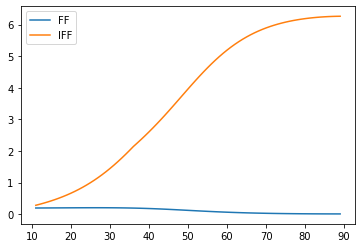

In [9]:
# Case 2 layup A

R, P, Fx = 75, 0, 100000


m = oppg_materiale
ff_fE_list = []
iff_fE_list = []
thetas = list(range(11, 90))
for theta in thetas:

    layupA = [{'mat':m, 'ori': theta, 'thi':0.5},
              {'mat':m, 'ori': -theta, 'thi':0.5}]
    t = laminateThickness(layupA)
    Nx=Fx/(2*np.pi*R)
    Ny=0
    Nxy=0
    
    
    A = computeA(layupA)
    Q = Q2D(m1)
    
    loads=[Nx,Ny,Nxy]
    strains_global=np.linalg.solve(A,loads)

    ff_candidates = []
    iff_fE_candidates = []
    for layer in layupA:
        angle = layer["ori"]
        strains = np.matmul(T2De(angle), strains_global)
        s = np.matmul(Q, strains)
        ff_candidates.append(ff_fE(s,m))
        iff_fE_candidates.append(fE_hashin([s[0], s[1], 0, s[2], 0, 0], m)[1])
        
        
    
    ff_fE_list.append(max(ff_candidates))
    iff_fE_list.append(max(iff_fE_candidates))
    #print(stresses_local[0])

plt.plot(thetas, ff_fE_list, label="FF")
plt.plot(thetas, iff_fE_list, label="IFF")
plt.legend()

In [ ]:
# Case 2 layup B

In [ ]:
# Case 3 layup A

In [ ]:
# Case 3 layup B

In [ ]:
# Case 4 layup A

In [ ]:
# Case 4 layup B

In [ ]:
# Case 5 layup A

In [ ]:
# Case 5 layup B